In [1]:
import pandas as pd
import numpy as np
import phate
import scprep

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from tqdm.autonotebook import tqdm

import torch, torch.nn as nn, torch.optim as optim, torch.nn.functional as F
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

from torchdyn.core import NeuralODE
from torchdyn.datasets import *
from torchdyn.nn import Augmenter
from torchdyn.models import CNF

import pytorch_lightning as pl

C:\Users\gania\AppData\Local\Temp\ipykernel_35804\2769589142.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Now we will create some toy data that resembles the latent space we might get in our embedding. Namely, a 2D blob of data that is transformed into another space.

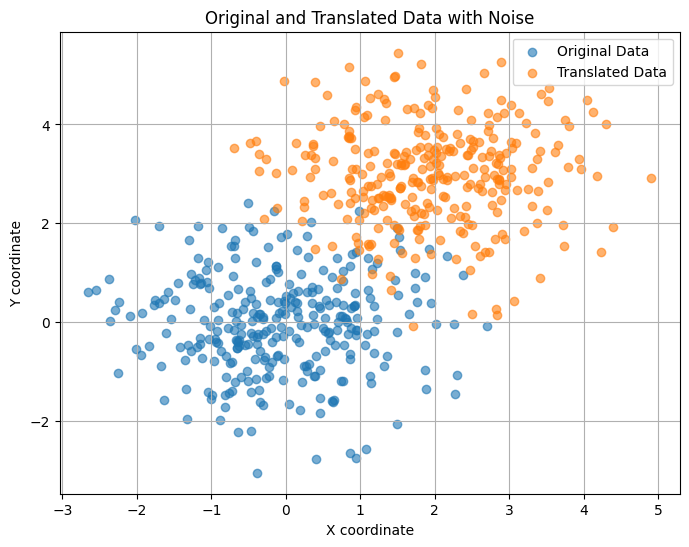

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Generate random 2D data as a blob
np.random.seed(0)
data = np.random.randn(300, 2)  # 100 points in 2D

# Define the translation vector and noise level
translation_vector = np.array([2, 3])
noise_level = 0.1

# Apply the translation and add Gaussian noise
translated_data = data + translation_vector + np.random.normal(scale=noise_level, size=data.shape)

X_train, X_test, Y_train, Y_test = train_test_split(data, translated_data)

# Plot the original and translated data
plt.figure(figsize=(8, 6))
plt.scatter(data[:, 0], data[:, 1], alpha=0.6, label='Original Data')
plt.scatter(translated_data[:, 0], translated_data[:, 1], alpha=0.6, label='Translated Data')
plt.title('Original and Translated Data with Noise')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.legend()
plt.grid(True)
plt.savefig('toy_data.png')

Now we will create our NeuralODE.

In [20]:
class Learner(pl.LightningModule):
    def __init__(self, t_span:torch.Tensor, model:nn.Module):
        super().__init__()
        self.model, self.t_span = model, t_span
    
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch      
        t_eval, y_hat = self.model(x, self.t_span)
        y_hat = y_hat[-1]
        loss = nn.MSELoss()(y_hat, y)
        return {'loss': loss}   
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=0.01)

    def train_dataloader(self):
        return trainloader

In [21]:
f = nn.Sequential(
        nn.Linear(2, 64),
        nn.Softplus(),
        nn.Linear(64, 64),
        nn.Softplus(),
        nn.Linear(64, 64),
        nn.Softplus(),
        nn.Linear(64, 2),
    )

model = NeuralODE(f, sensitivity='adjoint', solver='tsit5', interpolator=None, atol=1e-3, rtol=1e-3)

Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


Now we train the model.

In [22]:
from torch.utils.data import TensorDataset, DataLoader

t_span = torch.linspace(0, 1, steps=10)

X_train_torch = torch.Tensor(X_train)
Y_train_torch = torch.Tensor(Y_train)

X_test_torch = torch.Tensor(X_test)
Y_test_torch = torch.Tensor(Y_test)

train = TensorDataset(X_train_torch, Y_train_torch)
trainloader = DataLoader(train, batch_size=50, shuffle=True)

learn = Learner(t_span, model)
max_time = dict(minutes=15)
trainer = pl.Trainer(max_epochs=250, max_time=max_time)
trainer.fit(learn)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params
------------------------------------
0 | model | NeuralODE | 8.6 K 
------------------------------------
8.6 K     Trainable params
0         Non-trainable params
8.6 K     Total params
0.035     Total estimated model params size (MB)
c:\Users\gania\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\gania\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:298: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_s

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=250` reached.


To evaluate our model, we can analyze the vector field and some trajectories.

In [26]:
t_eval, trajectory = model(X_test_torch, t_span)
trajectory = trajectory.detach().cpu()
trajectory.shape

torch.Size([10, 75, 2])

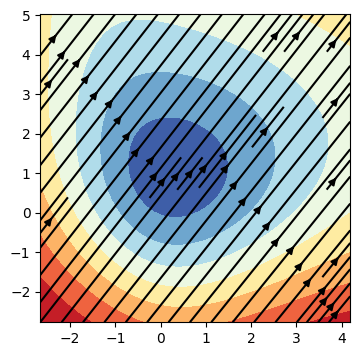

In [34]:
# evaluate vector field
n_pts = 50
x = torch.linspace(trajectory[:,:,0].min(), trajectory[:,:,0].max(), n_pts)
y = torch.linspace(trajectory[:,:,1].min(), trajectory[:,:,1].max(), n_pts)
X, Y = torch.meshgrid(x, y) ; z = torch.cat([X.reshape(-1,1), Y.reshape(-1,1)], 1)
f = model.vf(0,z).cpu().detach()
fx, fy = f[:,0], f[:,1] ; fx, fy = fx.reshape(n_pts , n_pts), fy.reshape(n_pts, n_pts)
# plot vector field and its intensity
fig = plt.figure(figsize=(4, 4)) ; ax = fig.add_subplot(111)
ax.streamplot(X.numpy().T, Y.numpy().T, fx.numpy().T, fy.numpy().T, color='black')
ax.contourf(X.T, Y.T, torch.sqrt(fx.T**2+fy.T**2), cmap='RdYlBu')
plt.savefig('toy_vector_field.png')

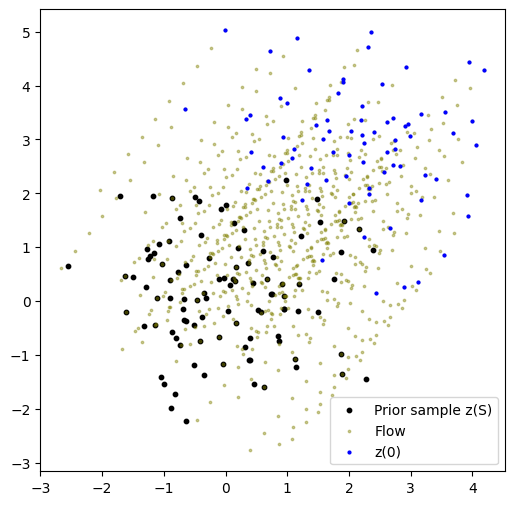

In [35]:
n = 100
plt.figure(figsize=(6,6))
plt.scatter(data[:n,0], data[:n,1], s=10, alpha=1, c='black')
plt.scatter(trajectory[:,:n,0], trajectory[:,:n,1], s=3, alpha=0.4, c='olive')
plt.scatter(trajectory[-1,:n,0], trajectory[-1,:n,1], s=4, alpha=1, c='blue')
plt.legend(['Prior sample z(S)', 'Flow', 'z(0)'])
plt.savefig('toy_trajectories.png')

The model looks pretty good from a visual perspective — we can apply a numeric metric by comuting the MSE with the final point in the trajectory. This will allow us to compare different iterations of models and tune our model accordingly.

In [32]:
from sklearn.metrics import mean_squared_error

y_pred = trajectory[-1,:n,:]
mean_squared_error(Y_test, y_pred)

0.009910592828364716